# Scientific paper agent using LangGraph

## Overview

add overview

## Motivation

add motivation


## Key components

add key components

## Method details

add method details

## Conclusion

add conclusion


## Import libraries

In [1]:
%pip install --upgrade --quiet arxiv google-search-results

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

True

## Build agent tools

In [3]:
from langchain_core.tools import tool
from langchain_community.utilities.arxiv import ArxivAPIWrapper
from pydantic import BaseModel, Field, model_validator
from serpapi import GoogleScholarSearch
from typing import Any

# Write Google Scholar API Wrapper
# NOTE: Langchain has a built in tool but it doesn't work
class GoogleScholarAPIWrapper(BaseModel):
    top_k_results: int = Field(description = "top k results obtained by running a query on GoogleScholarSearch")
    serp_api_key: str | None = None
    search_engine: Any | None = None

    @model_validator(mode = "before")
    def validate_env(cls, values: dict) -> dict:
        serp_api_key = values.get('serp_api_key')
        if serp_api_key is None:
            serp_api_key = os.environ["SERP_API_KEY"]
        GoogleScholarSearch.SERP_API_KEY = serp_api_key 
        values['search_engine'] = GoogleScholarSearch
        return values
        
    def run(self, query: str) -> str:
        page = 0
        all_results = []
        while page < max((self.top_k_results - 20), 1):
            results = (self.search_engine({"q": query, "start": page, "hl": "en",
                        "num": min(self.top_k_results, 20), "lr": "lang_en"}).get_dict().get("organic_results", []))
            all_results.extend(results)
            if not results:  
                break
            page += 20
        if (self.top_k_results % 20 != 0 and page > 20 and all_results):  # From the last page we would only need top_k_results%20 results
            results = (self.search_engine({"q": query,"start": page,"num": self.top_k_results % 20, "hl": "en", "lr": "lang_en"})
                .get_dict()
                .get("organic_results", []))
            all_results.extend(results)
        if not all_results:
            return "No good Google Scholar Result was found"
        docs = [
            f"Title: {result.get('title','')}\n"
            f"Authors: {','.join([author.get('name') for author in result.get('publication_info',{}).get('authors',[])])}\n"  # noqa: E501
            f"Summary: {result.get('publication_info',{}).get('summary','')}\n"
            f"Total-Citations: {result.get('inline_links',{}).get('cited_by',{}).get('total','')}"
            f"Link: {result.get('resources',[{}])[0].get('link','')}"
            for result in all_results
        ]
        return "\n\n".join(docs)

class GoogleScholarSearchInput(BaseModel):
    query: str = Field(description="The query to search for on arxiv. If the query is in the form of arxiv identifier, it will return the paper corresponding to the arxiv identifier. Otherwise, it will search for the paper using the query.")
    max_papers: int = Field(description="The maximum number of papers to return. It's default to 1, but you can increase it up to 10 in case you need to perform a more comprehensive search.", default=1, ge=1, le=10)


class ArxivSearchInput(BaseModel):
    id: str = Field(description="The arxiv id of the paper to search for.")


In [4]:
@tool("google-scholar-search", args_schema=GoogleScholarSearchInput)
def google_scholar_search(query: str, max_papers: int) -> str:
    """Academic search on google scholar.

    Example:
    {"query": "Attention is all you need", "max_papers": 1}

    Returns:
        A list of the relevant papers found with the corresponding summaries.
    """
    try:
        return GoogleScholarAPIWrapper(top_k_results=max_papers).run(query)
    except Exception as e:
        return f"Error performing google scholar search: {e}"

@tool("arxiv-search", args_schema=ArxivSearchInput)
def arxiv_search(id: str) -> str:
    """Search for one specific scientific paper on arxiv.

    Example:
    {"id": "2411.05749"}

    Returns:
        A list of the summaries of the papers.
    """
    try:
        arxiv_api_wrapper = ArxivAPIWrapper(
            top_k_results=1,
            load_max_docs=100,
            ARXIV_MAX_QUERY_LENGTH=1000,  # NOTE: can be chosen better based on the model. we can also summarize it in the tool to make it more scalable
            doc_content_chars_max=10000,  # NOTE: can be chosen better based on the model. if the overall content length is too long, we should handle it somehow  # ? summarization? truncate?
            load_all_available_meta=True,
        )
        if not arxiv_api_wrapper.is_arxiv_identifier(id):
            raise ValueError("The arxiv id is not valid")
        
        return arxiv_api_wrapper.run(id)
    except Exception as e:
        return f"Error performing arxiv search: {e}"


## Create agent

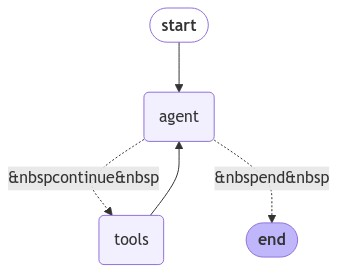

In [5]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display

# TODO: Write agent prompt
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)
tools = [google_scholar_search, arxiv_search]
prompt = SystemMessage(content="You are a helpful assistant that can search for scientific papers on arxiv and google scholar.")

langgraph_agent_executor = create_react_agent(
    llm, 
    tools=tools, 
    state_modifier=prompt
)

# Display agent graph
display(Image(langgraph_agent_executor.get_graph().draw_mermaid_png()))

## Run agent

In [6]:
test_inputs = [
    "what is the arxiv paper with id 1409.2329 about? provide a detailed summary of the content",
    "list all the authors of the paper 'Attention is all you need'?",
    "can you find me 8 papers on quantum machine learning?",
]

for test_input in test_inputs:
    messages = langgraph_agent_executor.invoke({"messages": [("user", test_input)]})
    out = messages['messages'][-1].content
    print(f"**Input:** {test_input}")
    print(f"**Output:** {out}")
    print("--------------------------------------------")


**Input:** what is the arxiv paper with id 1409.2329 about? provide a detailed summary of the content
**Output:** The paper titled "Recurrent Neural Network Regularization" (arXiv ID: 1409.2329) was published on February 19, 2015, by authors Wojciech Zaremba, Ilya Sutskever, and Oriol Vinyals. 

### Summary of the Content:

The paper addresses the challenge of regularizing Recurrent Neural Networks (RNNs), particularly those utilizing Long Short-Term Memory (LSTM) units. Regularization is crucial in machine learning to prevent overfitting, which occurs when a model learns the training data too well, including its noise and outliers, leading to poor generalization on unseen data.

#### Key Points:

1. **Dropout in Neural Networks**: 
   - Dropout is a widely used regularization technique that involves randomly setting a fraction of the input units to zero during training. This helps to prevent co-adaptation of hidden units, thereby improving the model's ability to generalize.

2. **Chal